In [1]:
import os
import h5py
import numpy as np
import geopandas as gpd
import pandas as pd
from tqdm import tqdm

# Define paths
parent_folder = "temp"  # Folder containing area-specific folders with CSVs
grid_file = "../population_and_employment/grid_1km_653_573/grid_cells.shp"
output_h5_file = "landuse_and_poi-230101.h5"

# Load grid
grid = gpd.read_file(grid_file)
num_grids = len(grid)
num_channels = 12  # Update based on your specific number of channels

# Get grid shape for 3D reshaping
rows, cols = 653, 573

# Initialize a tensor
result_tensor = np.zeros((rows, cols, num_channels))

# Iterate over each grid index with tqdm
print("Processing grids...")
for idx in tqdm(range(num_grids), desc="Grid Progress"):
    row, col = divmod(idx, cols)  # Calculate row and column indices
    # Find matching CSVs in each area folder
    for area_folder in os.listdir(parent_folder):
        area_folder_path = os.path.join(parent_folder, area_folder)
        if not os.path.isdir(area_folder_path):
            continue

        # Path to the matching CSV for this grid index
        csv_path = os.path.join(area_folder_path, f"{idx}.csv")
        if os.path.exists(csv_path):
            # Read the CSV and add values to the tensor
            data = pd.read_csv(csv_path).values.squeeze()  # Assuming one row per CSV
            result_tensor[row, col, :] += data

# Save the result tensor to an H5 file
with h5py.File(output_h5_file, "w") as h5f:
    h5f.create_dataset("features", data=result_tensor)

print(f"Saved the merged tensor to {output_h5_file} with shape {result_tensor.shape}.")

Processing grids...


Grid Progress: 100%|██████████| 374169/374169 [19:06<00:00, 326.44it/s]

Saved the merged tensor to landuse_and_poi-230101.h5 with shape (653, 573, 12).


In [6]:
import h5py
import numpy as np

# Define the file path
h5_file_path = "landuse_and_poi-230101.h5"

# Read the H5 file
with h5py.File(h5_file_path, "r") as h5f:
    # Load the dataset
    feature_data = np.array(h5f["features"])

# Print the shape of the loaded data
print(f"Loaded data shape: {feature_data.shape}")

Loaded data shape: (653, 573, 12)


Visualizing channels...


Visualization Progress: 100%|██████████| 12/12 [00:00<00:00, 192.09it/s]


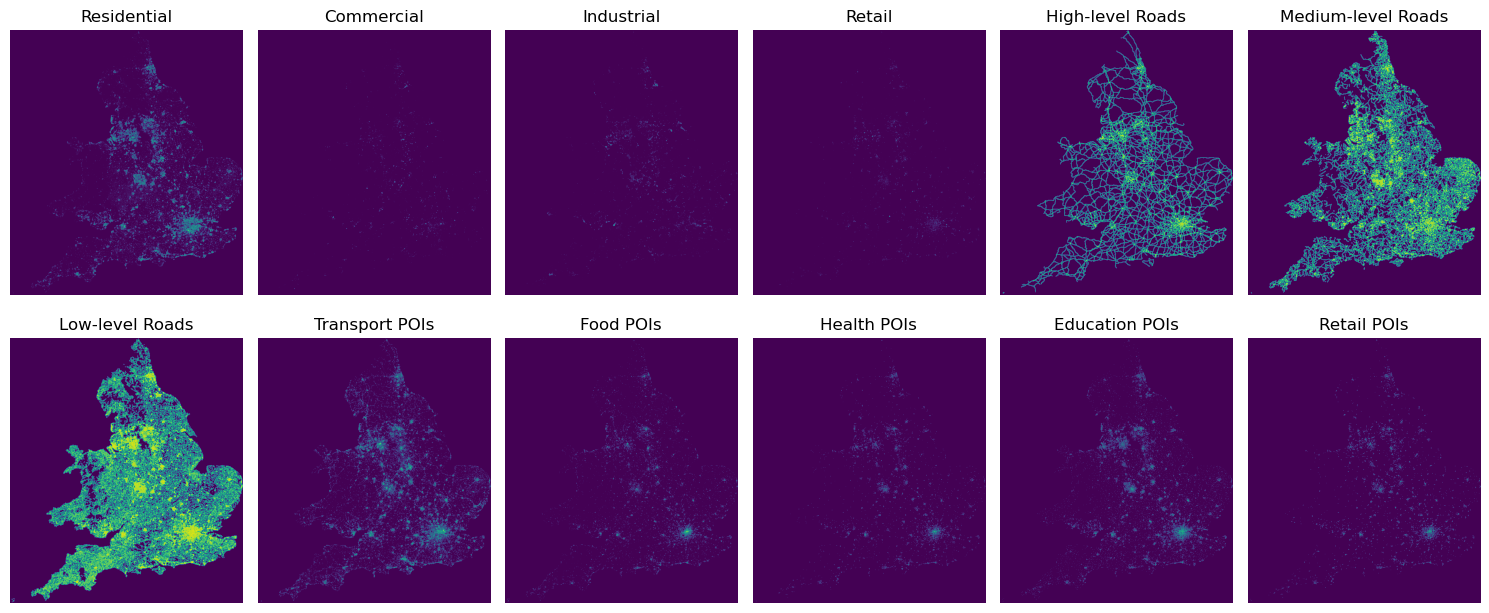

In [10]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define channel names
channel_names = [
    "Residential", "Commercial", "Industrial", "Retail", #"Education", "Institutional",
    "High-level Roads", "Medium-level Roads", "Low-level Roads",
    "Transport POIs", "Food POIs", "Health POIs", "Education POIs", "Retail POIs"
]

# Extract dimensions
rows, cols, num_channels = feature_data.shape

# Visualize each channel
fig, axes = plt.subplots(2, 6, figsize=(15, 6.5))  # Adjust based on number of channels
axes = axes.flatten()

print("Visualizing channels...")
for i in tqdm(range(num_channels), desc="Visualization Progress"):
    ax = axes[i]
    ax.imshow(np.log10(1+feature_data[:, :, i]), cmap="viridis", aspect="equal")
    ax.set_title(channel_names[i])  # Set subplot title to channel name
    ax.axis("off")  # Turn off axes for cleaner visualization

# Hide any unused subplots
for j in range(num_channels, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.savefig('landuse_and_poi_channels.png')
plt.show()

In [7]:
# Compute the sum of each channel
channel_sums = feature_data.sum(axis=(0, 1))  # Sum over rows and columns

# Define channel names
channel_names = [
    "Residential", "Commercial", "Industrial", "Retail", #"Education", "Institutional",
    "High-level Roads", "Medium-level Roads", "Low-level Roads",
    "Transport POIs", "Food POIs", "Health POIs", "Education POIs", "Retail POIs"
]

# Print the sum for each channel
for i, channel_name in enumerate(channel_names):
    print(f"Channel '{channel_name}' sum: {channel_sums[i]:.2f}")

Channel 'Residential' sum: 10500.79
Channel 'Commercial' sum: 283.66
Channel 'Industrial' sum: 1406.26
Channel 'Retail' sum: 249.55
Channel 'High-level Roads' sum: 53191051.19
Channel 'Medium-level Roads' sum: 79833751.05
Channel 'Low-level Roads' sum: 232731595.60
Channel 'Transport POIs' sum: 191281.00
Channel 'Food POIs' sum: 63423.00
Channel 'Health POIs' sum: 11728.00
Channel 'Education POIs' sum: 33122.00
Channel 'Retail POIs' sum: 10702.00


In [1]:
import h5py
import numpy as np

# Define the file path
h5_file_path_old = "landuse_and_poi_c14.h5"
h5_file_path_new = "landuse_and_poi_c12.h5"

# Load the existing H5 file
with h5py.File(h5_file_path_old, "r") as h5f:
    feature_data = np.array(h5f["features"])

# Define the channel names
channel_names = [
    "Residential", "Commercial", "Industrial", "Retail", "Education", "Institutional",
    "High-level Roads", "Medium-level Roads", "Low-level Roads",
    "Transport POIs", "Food POIs", "Health POIs", "Education POIs", "Retail POIs"
]

# Indices of channels to delete
channels_to_delete = [4, 5]  # Indices for "Education" and "Institutional"

# Delete the specified channels
new_feature_data = np.delete(feature_data, channels_to_delete, axis=2)

# Remove the corresponding channel names
new_channel_names = [name for i, name in enumerate(channel_names) if i not in channels_to_delete]

# Save the updated tensor back to the same H5 file
with h5py.File(h5_file_path_new, "w") as h5f:
    h5f.create_dataset("features", data=new_feature_data)

print(f"Updated H5 file saved with shape: {new_feature_data.shape}")

Updated H5 file saved with shape: (653, 573, 12)
